# Run mode

In [300]:
splitMode = "5fold" # "10fold"  "15fold"    "COVID" "Pre-COVID"
runMode = "FinalModel" # this will only run the best fitting model 5 feature k-fold split with the best parameters, comment out this code to run hyperparameter tuning

# Splits

***In this section, the split can be chosen. Brief Summary of Each Section:***

**COVID Split:** Train values for years < 2019, test for >=2019. More of an expiriment to see what the model predicted would happen if COVID did not happen.

**K-Fold Split:** Using TimeSeriesSplit with 5 folds for all features.

**K-Fold Split with Ommited Features:** TimeSeriesSplit using the top 10 correlated features. 


In [301]:

from output_util import OutputUtil
from globals import BINNING_OUTPUT_PATH

outputUtil = OutputUtil()

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


### K-Fold Split with top 5 features

In [302]:
data = pd.read_csv(BINNING_OUTPUT_PATH)

if splitMode == "5fold":
    top = ['Total Expenses',
            'Total Revenues',
            'Net property taxes and payments in lieu of taxes',
            'Protective Services',
            'Transportation Services',
            'General Government Services',
            'Year']

if splitMode == "10fold":
    top = ['Total Expenses',
        'Total Revenues',
        'Net property taxes and payments in lieu of taxes',
        'Protective Services',
        'Transportation Services',
        'General Government Services',
        'Grants In Lieu Of Taxes',
        'Population',
        'Recreation And Cultural Services',
        'Land Area Size',
        'Other Revenue From Own Sources',
        'Year']
    
    data['Land Area Size'] = LabelEncoder().fit_transform(data['Land Area Size'])

if splitMode == "15fold":
    top = ['Total Expenses',
        'Total Revenues',
        'Net property taxes and payments in lieu of taxes',
        'Protective Services',
        'Transportation Services',
        'General Government Services',
        'Grants In Lieu Of Taxes',
        'Population',
        'Recreation And Cultural Services',
        'Land Area Size',
        'Other Revenue From Own Sources',
        'Year',
        'Operating surplus (deficit) before financing and transfers',
        'Sales Of Services',
        'Environmental Development Services',
        'Environmental Health Services',
        'Population Density']
    
    data['Land Area Size'] = LabelEncoder().fit_transform(data['Land Area Size'])



data = data[top]
data.sort_values('Year', inplace=True)

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

X_train = train_data.drop(columns=['Total Expenses'])
y_train = train_data['Total Expenses']
X_test = test_data.drop(columns=['Total Expenses'])
y_test = test_data['Total Expenses']



### COVID split

In [303]:
df = pd.read_csv(BINNING_OUTPUT_PATH)

top = ['Total Expenses',
        'Total Revenues',
        'Net property taxes and payments in lieu of taxes',
        'Protective Services',
        'Transportation Services',
        'General Government Services',
        'Year']

if splitMode == "COVID":
        
        df = df[top]
        df = df.sort_values(by='Year')

        split_year = 2019

        covid_train_df = df[df['Year'] < split_year]
        covid_test_df = df[df['Year'] >= split_year]

        X_train = covid_train_df.drop(columns=['Total Expenses'])
        y_train = covid_train_df['Total Expenses']
        X_test = covid_test_df.drop(columns=['Total Expenses'])
        y_test = covid_test_df['Total Expenses']


if splitMode == "Pre-COVID":

        df = df[top]
        df = df.sort_values(by='Year')


        train_end_year = 2017
        test_start_year = 2018
        test_end_year = 2019


        covid_train_df = df[(df['Year'] >= 2013) & (df['Year'] <= train_end_year)]  # Training data from 2013 to 2017
        covid_test_df = df[(df['Year'] >= test_start_year) & (df['Year'] <= test_end_year)]  # Test data for 2018 and 2019

        X_train = covid_train_df.drop(columns=['Total Expenses'])
        y_train = covid_train_df['Total Expenses']
        X_test = covid_test_df.drop(columns=['Total Expenses'])
        y_test = covid_test_df['Total Expenses']


# Grids

### Initial Grid

In [304]:
#initial grid

#get broad values
gb_grid = {
    'n_estimators': np.arange(100, 20000, 1000),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.75, 1.0],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 3, 5]
}

#### Results from COVID

Test RMSE: 5335755.99196708
Mean of test set: 72304098.47058824
Percentage error relative to test set mean: 7.379603791253343%
Test R^2: 0.9989067110074029
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1900, 'subsample': 0.5}

#### Pre - COVID

Test RMSE: 9816262.29738378
Mean of test set: 71080475.79411764
Percentage error relative to test set mean: 13.81006835944131%
Test R^2: 0.9961784660577737
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400, 'subsample': 1.0}

#### Results ommited 5

Test RMSE: 6788636.990805412
Mean of test set: 91624888.0909091
Percentage error relative to test set mean: 7.409162654659735%
Test R^2: 0.998807736889163
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1600, 'subsample': 0.5}

#### Results ommited 10

Test RMSE: 8411426.234333282
Mean of test set: 91624888.0909091
Percentage error relative to test set mean: 9.180285411085652%
Test R^2: 0.9981695991208444
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1800, 'subsample': 0.5}

#### Results ommited 15

Test RMSE: 10418555.260041632
Mean of test set: 91624888.0909091
Percentage error relative to test set mean: 11.370879110601988%
Test R^2: 0.9971918394524996
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1900, 'subsample': 0.5}

#### Results from all

Since raising the number of features to 20 resulted in a much higher error, it is assumed that using all features will make it even worse

### Finer Tuning

will only focus on the top 2 preformers

#### Grids for top 5

##### Results ommited 5

Test RMSE: 6788636.990805412
Mean of test set: 91624888.0909091
Percentage error relative to test set mean: 7.409162654659735%
Test R^2: 0.998807736889163
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1600, 'subsample': 0.5}

In [305]:
gb_grid = {
    'n_estimators': np.arange(1500, 1700, 50),
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
    'max_depth': [6, 7, 8, 9],
    'subsample': [0.4,0.5,0.6],
    'min_samples_split': [3, 5, 7], 
    'min_samples_leaf': [1, 2]
}


##### Results ommited 5 REV2

Test RMSE: 5481181.6854663445
Mean of test set: 91624888.0909091
Percentage error relative to test set mean: 5.982197413466943%
Test R^2: 0.9992227596650322
Best parameters: {'learning_rate': 0.12, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1500, 'subsample': 0.4}

In [306]:
gb_grid = {
    'n_estimators': np.arange(1300, 1500, 50),
    'learning_rate': [0.12, 0.13, 0.14],
    'max_depth': [6], #must be 6 if 5 or 7 are not the best 
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'min_samples_split': [3, 4], # not 5, not 2
    'min_samples_leaf': [1] #must be 1
}

#### Grids for COVID

##### Results from COVID

Test RMSE: 5335755.99196708
Mean of test set: 72304098.47058824
Percentage error relative to test set mean: 7.379603791253343%
Test R^2: 0.9989067110074029
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1900, 'subsample': 0.5}


In [307]:
gb_grid = {
    'n_estimators': np.arange(1600, 2000, 50),
    'learning_rate': [0.02 ,0.03 ,0.04, 0.05],
    'max_depth': [4, 5, 6],
    'subsample': [0.2,0.3,0.4,0.5],
    'min_samples_split': [3,4, 5,6,7,8,9], 
    'min_samples_leaf': [1, 2]
}

##### Results from COVID REV2

Test RMSE: 5330870.429142737
Mean of test set: 72304098.47058824
Percentage error relative to test set mean: 7.372846825980717%
Test R^2: 0.9989087121808944
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 1950, 'subsample': 0.5}


In [308]:
gb_grid = {
    'n_estimators': np.arange(1950, 2250, 50),
    'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09],
    'max_depth': [5], #must be 5
    'subsample': [0.5, 0.6, 0.7],
    'min_samples_split': [9], #must be 9
    'min_samples_leaf': [1] #must be 1
}

##### Results from COVID REV3

Test RMSE: 5330864.011949338
Mean of test set: 72304098.47058824
Percentage error relative to test set mean: 7.3728379506976625%
Test R^2: 0.998908714808233
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 2200, 'subsample': 0.5}

In [309]:
gb_grid = {
    'n_estimators': np.arange(2200, 20000, 50),
    'learning_rate': [0.05], #must be close to this
    'max_depth': [5], #must be 5
    'subsample': [0.5], #must be close to this
    'min_samples_split': [9], #must be 9
    'min_samples_leaf': [1] #must be 1
}

##### Results from COVID REV4

Test RMSE: 5330862.91307951
Mean of test set: 72304098.47058824
Percentage error relative to test set mean: 7.372836430908534%
Test R^2: 0.998908715258134
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 5350, 'subsample': 0.5}

# Hyperparameter Tuning

### Functions

In [310]:
def perform_grid_search(X_train, y_train, scoring_metric, gb_grid):

    
    # Initialize and fit GridSearchCV
    gb_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_grid, cv=5, 
                             scoring=scoring_metric, verbose=1, n_jobs=-1)
    gb_search.fit(X_train, y_train)
    
    return gb_search

def evaluate_model(gb_search, X_test, y_test):
    # Making predictions using the best estimator
    test_predictions = gb_search.best_estimator_.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    percentage_error = (test_rmse / y_test.mean()) * 100
    test_r2 = r2_score(y_test, test_predictions)
    
    print(f"Test RMSE: {test_rmse}")
    print(f"Mean of test set: {y_test.mean()}")
    print(f"Percentage error relative to test set mean: {percentage_error}%")
    print(f"Test R^2: {test_r2}")
    print(f"Best parameters: {gb_search.best_params_}\n")


### Getting best params

In [311]:
if runMode == "FinalModel":
    pass

else:
    gb_search_nmse = perform_grid_search(X_train, y_train, 'neg_mean_squared_error', gb_grid)
    evaluate_model(gb_search_nmse, X_test, y_test)

### Final Result

Best split is 5 top correlated features, with the parameters:  
Test RMSE: 5481181.685383935
Mean of test set: 91624888.0909091
Percentage error relative to test set mean: 5.982197413377001%
Test R^2: 0.9992227596650556
Best parameters: {'learning_rate': 0.12, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400, 'subsample': 0.4}


# Final Model And Graphing

In [312]:
from sklearn.ensemble import GradientBoostingRegressor

# Given best parameters
params = {
    'learning_rate': 0.12,
    'max_depth': 6,
    'min_samples_leaf': 1,
    'min_samples_split': 3,
    'n_estimators': 1400,
    'subsample': 0.4
}

gbm_final = GradientBoostingRegressor(**params)

gbm_final.fit(X_train, y_train)



GradientBoostingRegressor(learning_rate=0.12, max_depth=6, min_samples_split=3,
                          n_estimators=1400, subsample=0.4)

In [313]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize sums
sum_rmse = 0
sum_r2 = 0

# Number of iterations
iterations = 50

# Run the loop to accumulate the values
for i in range(iterations):
    gbm_final.fit(X_train, y_train)
    test_predictions = gbm_final.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    sum_rmse += test_rmse  # Add to the sum of RMSEs
    test_r2 = r2_score(y_test, test_predictions)
    sum_r2 += test_r2  # Add to the sum of R2s

# Calculate the averages
avg_rmse = sum_rmse / iterations
avg_r2 = sum_r2 / iterations

# Calculate average percentage error
avg_percentage_error = (avg_rmse / y_test.mean()) * 100

# Print the results
print(f'Average RMSE over {iterations} iterations: {avg_rmse}')
print(f'Average R2 over {iterations} iterations: {avg_r2}')
print(f'Average Percentage Error over {iterations} iterations: {avg_percentage_error}')


Average RMSE over 50 iterations: 6703723.075133378
Average R2 over 50 iterations: 0.9988231300490046
Average Percentage Error over 50 iterations: 7.316487053694434


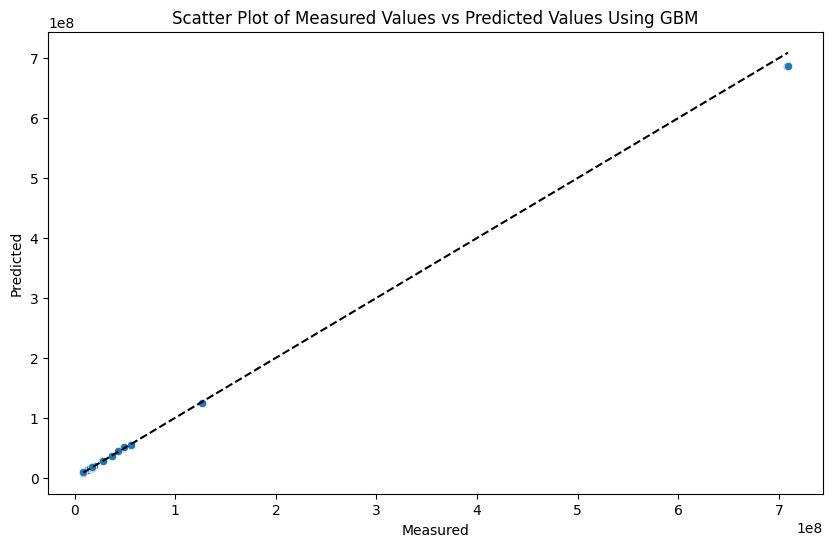

In [314]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = gbm_final.predict(X_test)
residuals = y_test - y_pred

# 1. Scatter Plot with Best Fit Line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color = 'black')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Scatter Plot of Measured Values vs Predicted Values Using GBM')
plt.show()



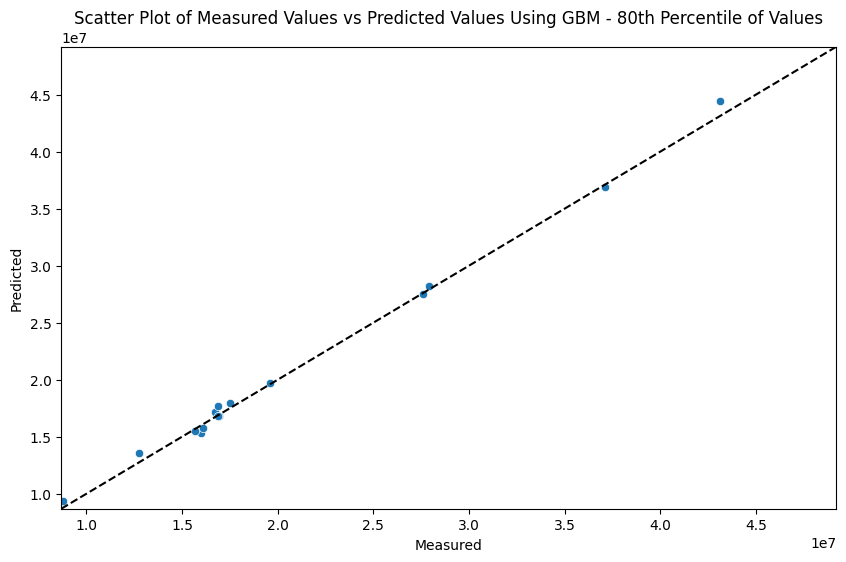

In [320]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)

# Define the limits for the axes that exclude the outlier
max_limit = np.percentile(y_test, 80)  # For example, this takes the 99th percentile as the max limit
min_limit = np.percentile(y_test, 1)   # Similarly, this takes the 1st percentile as the min limit

# Plot only within the defined limits
plt.xlim(min_limit, max_limit)
plt.ylim(min_limit, max_limit)

# Add a 'best fit' line within the new limits
plt.plot([min_limit, max_limit], [min_limit, max_limit], '--', color = 'black')

plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Scatter Plot of Measured Values vs Predicted Values Using GBM - 80th Percentile of Values')
plt.show()


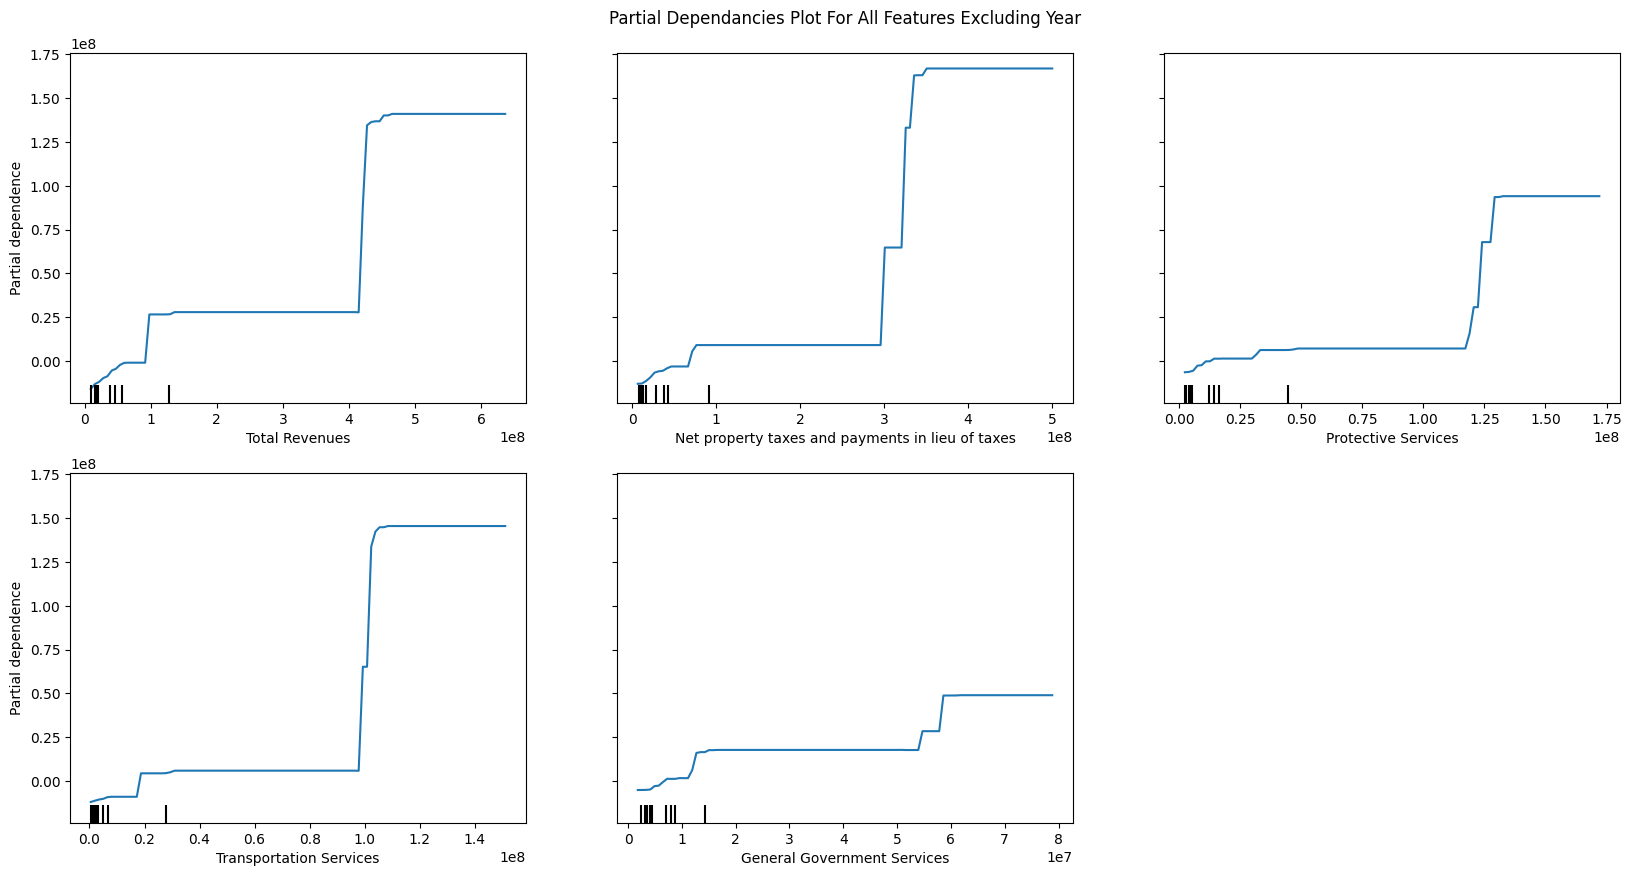

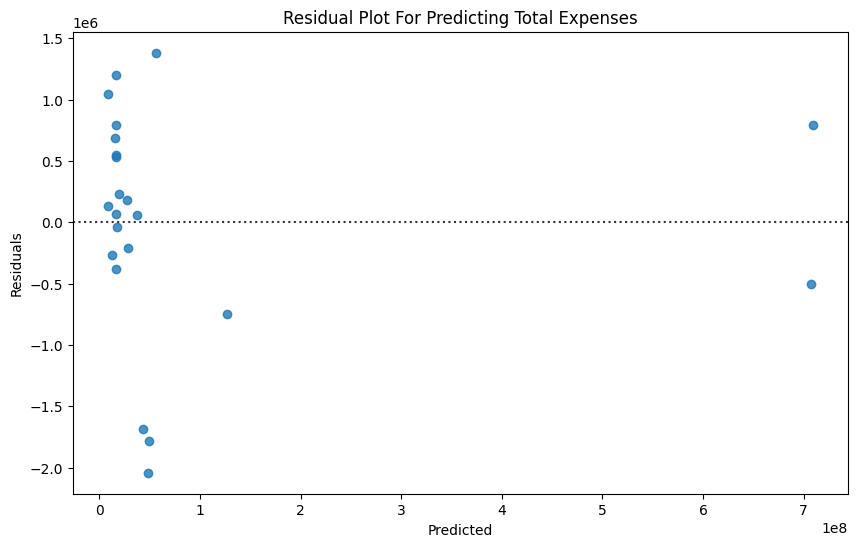

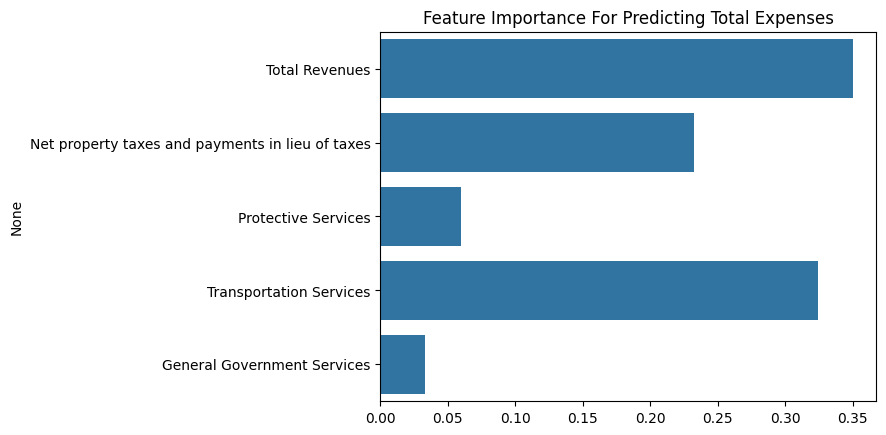

In [316]:
from sklearn.inspection import PartialDependenceDisplay

features = ['Total Revenues',
            'Net property taxes and payments in lieu of taxes',
            'Protective Services',
            'Transportation Services',
            'General Government Services']


fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Partial Dependancies Plot For All Features Excluding Year\n')
PartialDependenceDisplay.from_estimator(gbm_final, X_train, features, ax=ax)
plt.show()


# 2. Residual Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot For Predicting Total Expenses')
plt.show()

feature_importance = gbm_final.feature_importances_
feature_importance_series = pd.Series(feature_importance, index=X_train.columns)
feature_importance_series = feature_importance_series.drop('Year')
sns.barplot(x=feature_importance_series.values, y=feature_importance_series.index)
plt.title('Feature Importance For Predicting Total Expenses')
plt.show()


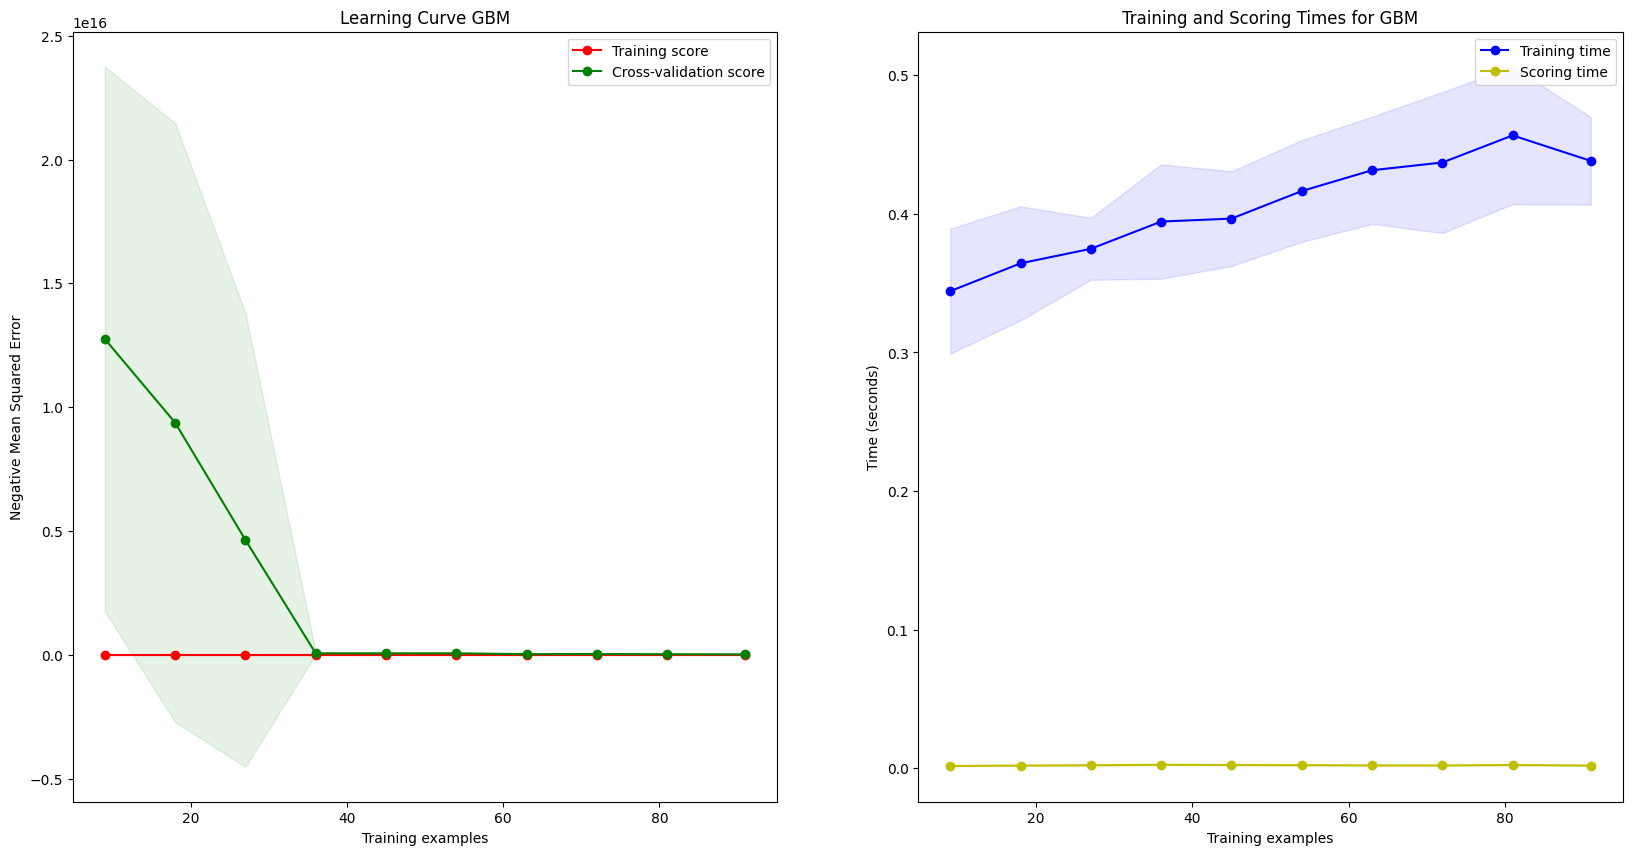

In [317]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt



train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
estimator=gbm_final,
X=X_train,
y=y_train,
train_sizes=np.linspace(0.1, 1.0, 10),
cv=5,
scoring='neg_mean_squared_error',
n_jobs=14,
shuffle=True,
random_state=42,
return_times=True
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fit_time_mean = np.mean(fit_times, axis=1)
fit_time_std = np.std(fit_times, axis=1)
score_time_mean = np.mean(score_times, axis=1)
score_time_std = np.std(score_times, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(train_sizes, -train_mean, 'o-', color="r", label="Training score")
ax1.plot(train_sizes, -test_mean, 'o-', color="g", label="Cross-validation score")
ax1.fill_between(train_sizes, -train_mean - train_std, -train_mean + train_std, alpha=0.1, color="r")
ax1.fill_between(train_sizes, -test_mean - test_std, -test_mean + test_std, alpha=0.1, color="g")
ax1.set_title(f'Learning Curve GBM')
ax1.set_xlabel('Training examples')
ax1.set_ylabel('Negative Mean Squared Error')
ax1.legend(loc="best")

ax2.plot(train_sizes, fit_time_mean, 'o-', color="b", label="Training time")
ax2.fill_between(train_sizes, fit_time_mean - fit_time_std, fit_time_mean + fit_time_std, alpha=0.1, color="b")
ax2.plot(train_sizes, score_time_mean, 'o-', color="y", label="Scoring time")
ax2.fill_between(train_sizes, score_time_mean - score_time_std, score_time_mean + score_time_std, alpha=0.1, color="y")
ax2.set_title(f'Training and Scoring Times for GBM')
ax2.set_xlabel('Training examples')
ax2.set_ylabel('Time (seconds)')
ax2.legend(loc="best")